# Loading and cleaining

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor 
from xgboost import plot_importance
import pylab as pl
from sklearn.cross_validation import train_test_split

In [6]:
df = pd.read_csv('data_input.csv', sep=';', index_col='Inst ID', thousands=',')
df.head()

,L,mu,cvr,f,m,cs/cw,S,costs,LB 95% CI,UB 95% CI,avg short,avg waste
Inst ID,,,,,,,,,,,,
1,0,2,5,0%,3,1,2,310.0,308.0,312.0,"11,6%","0,4%"
22,0,2,5,50%,3,1,2,242.0,241.0,243.0,"10,9%","0,1%"
23,0,2,5,50%,3,2,3,367.0,364.0,370.0,"0,8%","1,7%"
24,0,2,5,50%,3,5,3,414.0,411.0,418.0,"0,8%","1,7%"
25,0,2,5,50%,3,1,3,493.0,489.0,497.0,"0,8%","1,7%"


In [7]:
df.columns

Index(['L', 'mu', 'cvr', 'f', 'm', 'cs/cw', 'S', 'costs', 'LB 95% CI',
       'UB 95% CI', 'avg short', 'avg waste'],
      dtype='object')

In [8]:
df.drop(['costs','LB 95% CI','UB 95% CI','avg short','avg waste'], axis=1, inplace=True)
df['f'] = df['f'].str.rstrip('%').astype('float') / 100.0

# Exploration

In [22]:
df.describe()

,L,mu,cvr,f,m,cs/cw,S
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000
mean,1.064737,4.563969,6.172357,0.436645,4.588659,3.627761,13.612286
std,0.807465,3.101154,5.647150,0.370346,2.401306,2.941700,10.899727
min,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000
25%,0.000000,2.000000,2.000000,0.000000,3.000000,1.000000,5.000000
50%,1.000000,4.000000,2.000000,0.500000,4.000000,2.000000,11.000000
75%,2.000000,6.000000,15.000000,0.800000,6.000000,5.000000,19.000000
max,2.000000,10.000000,15.000000,1.000000,10.000000,10.000000,64.000000


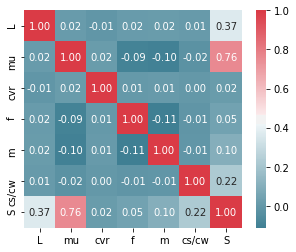

In [9]:
def correlation_plot():
    f, ax = pl.subplots(figsize=(5, 4))

    corr = df[['L', 'mu', 'cvr', 'f', 'm', 'cs/cw','S']].corr() 
                         
    return sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)

correlation_plot()

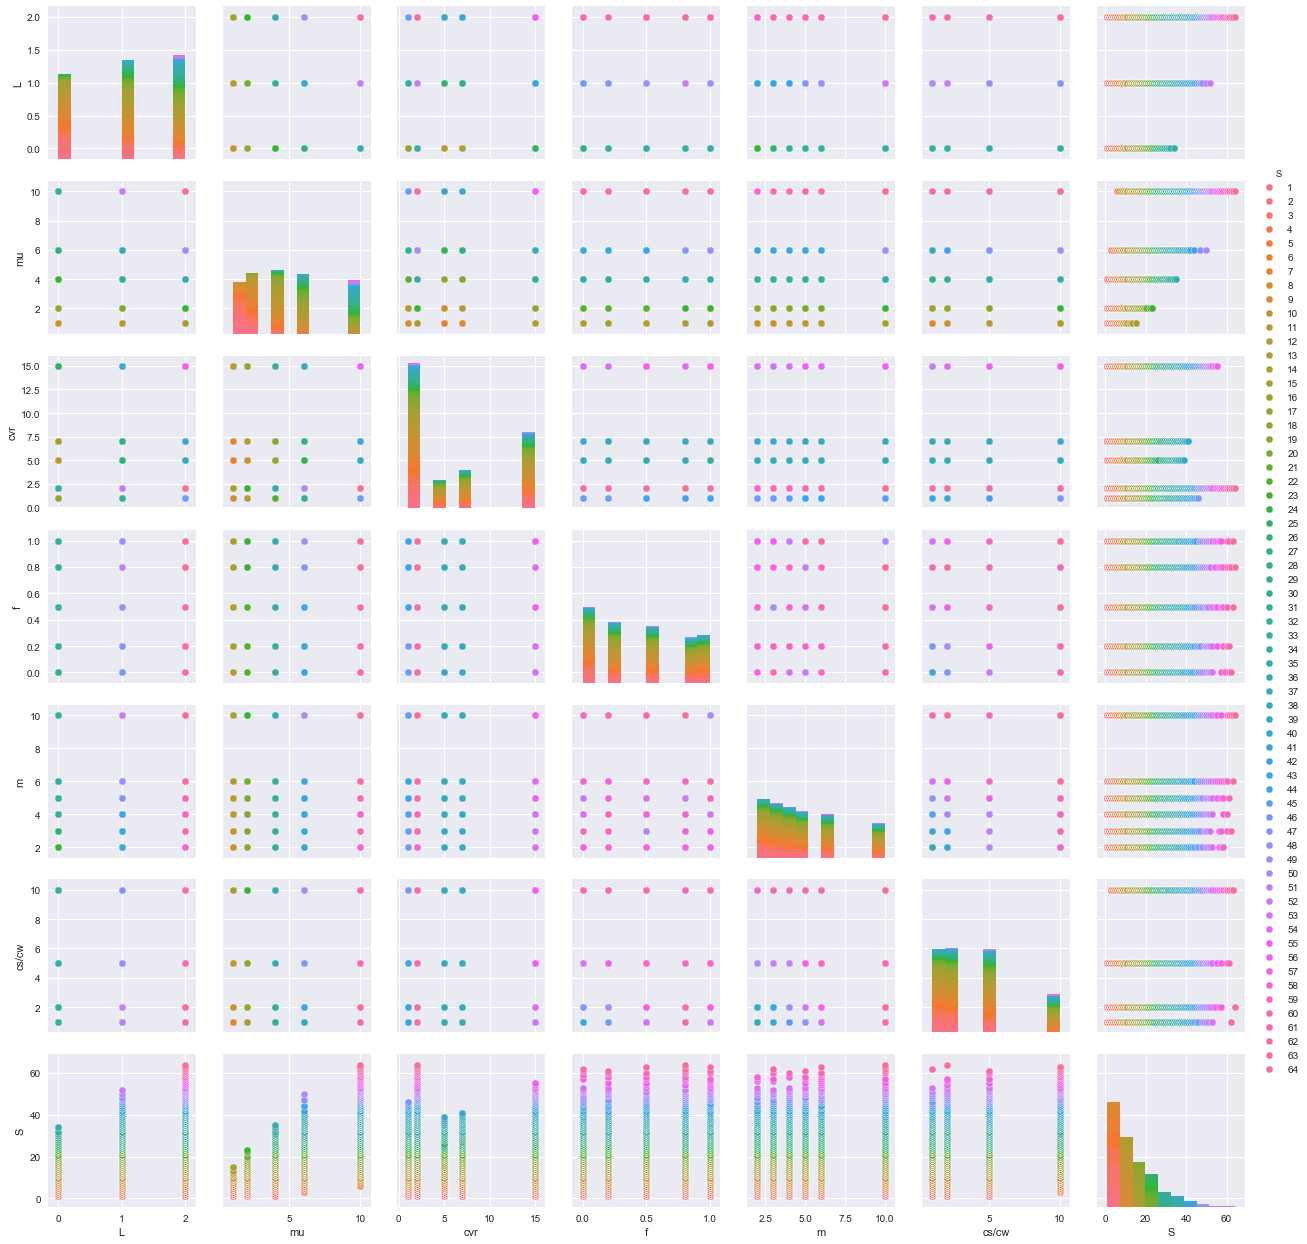

In [10]:
sns.set()
sns.pairplot(df,hue="S")

# Model training

In [48]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

In [62]:
# Loading example data
X = df.drop(['S'],1)
y = np.array(df['S'])

# Training regressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
ada = AdaBoostRegressor()
xgb = XGBRegressor(colsample_bytree= 0.5, learning_rate=0.1, max_depth= 5, min_child_weight= 10, 
                    n_estimators= 1000, nthread= 4, objective= 'reg:linear', silent= 1, subsample= 0.5)
lr = LinearRegression()

#evaluate the regressor
labels = ['RandomForestRegressor', 'AdaBoostRegressor', 'XGBRegressor','LinearRegression']

for regr, label in zip([rf, ada, xgb, lr], labels):

    scores_mse = cross_val_score(regr, X, y, 
                                cv=10, 
                                scoring='neg_mean_squared_error')
    print("MSE: %0.3f (+/- %0.4f) [%s]"% (scores_mse.mean(), scores_mse.std(), label))
    
    scores_mae = cross_val_score(regr, X, y, 
                                cv=10, 
                                scoring='neg_mean_absolute_error')
    print("MAE: %0.3f (+/- %0.4f) [%s]"% (scores_mae.mean(), scores_mae.std(), label))

#fit the model
rf = rf.fit(X,y)
ada = ada.fit(X,y)
xgb = xgb.fit(X,y)
lr = lr.fit(X,y)


MSE: -31.238 (+/- 36.6637) [RandomForestRegressor]
MAE: -3.800 (+/- 2.5894) [RandomForestRegressor]
MSE: -48.401 (+/- 41.7418) [AdaBoostRegressor]
MAE: -5.268 (+/- 2.3883) [AdaBoostRegressor]
MSE: -16.016 (+/- 23.3400) [XGBRegressor]
MAE: -2.767 (+/- 1.8237) [XGBRegressor]
MSE: -33.457 (+/- 32.7724) [LinearRegression]
MAE: -4.329 (+/- 2.0422) [LinearRegression]


In [63]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    try:
        coefs = pd.DataFrame(model.coef_, X.columns)
    except:
        coefs = pd.DataFrame(model.feature_importances_, X.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    pl.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    pl.grid(True, axis='y')
    pl.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

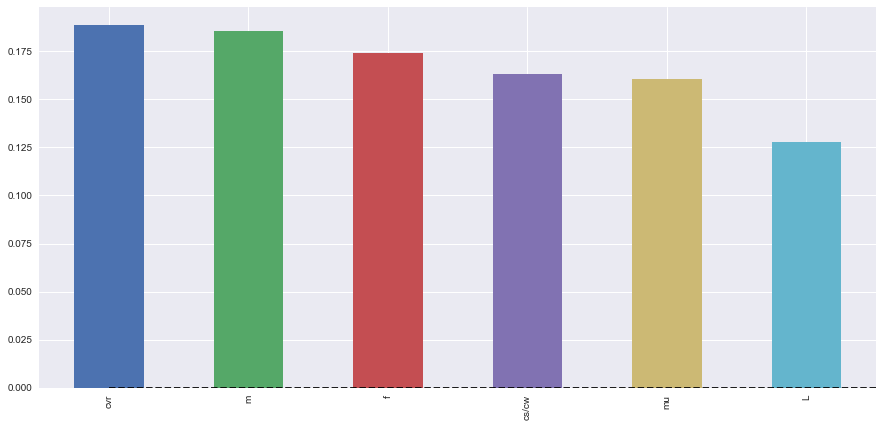

In [64]:
plotCoefficients(xgb)

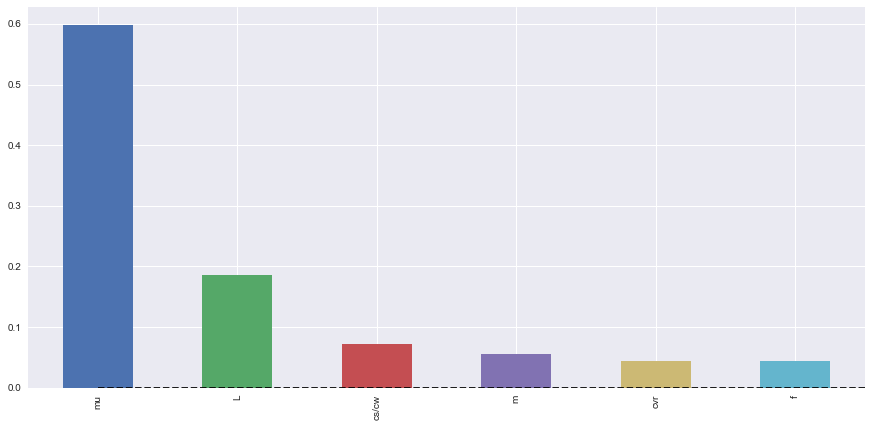

In [65]:
plotCoefficients(rf)

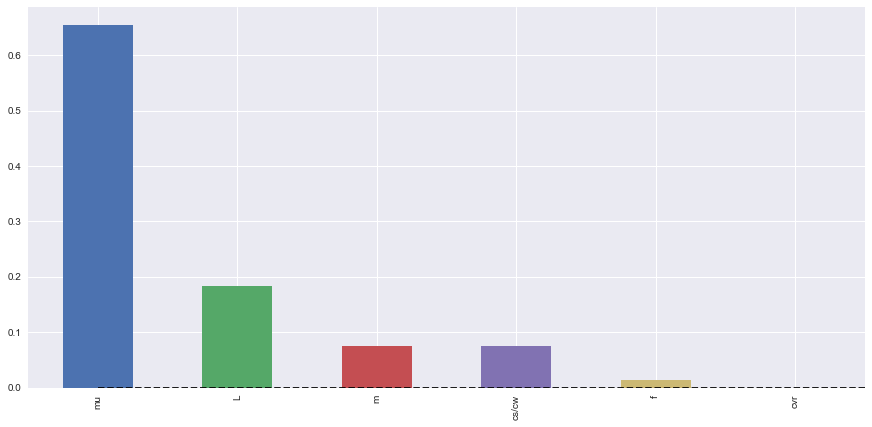

In [66]:
plotCoefficients(ada)

# Plot residuals and jointplot

These plots will show the performance of our model based on a jointplot where the x-axis contains the predicted S of the model and the y-axis shows the true value of S. The line is a linear regression line to show the pearson r score of this model

In [67]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (6772, 6)
Training Labels Shape: (6772,)
Testing Features Shape: (1693, 6)
Testing Labels Shape: (1693,)


In [68]:
def plot_joint_and_r_squared(model, X_train=X_train, X_test=X_test):
    prediction_model = model.predict(X_test)
    d = {'model_prediction': prediction_model, 'true_value': y_test}
    df = pd.DataFrame(data=d)
    sns.jointplot(x="model_prediction", y="true_value", data=df, kind="reg").fig.set_figwidth(15)
    #return df

def plot_residuals(model, X_train=X_train, X_test=X_test):
    prediction_model = model.predict(X_test)
    d = {'model_prediction': prediction_model, 'difference_true': y_test}
    df = pd.DataFrame(data=d)
    pl.figure(figsize=(15,8))
    sns.residplot(x="model_prediction", y="difference_true", data=df, lowess=True, color="g")

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


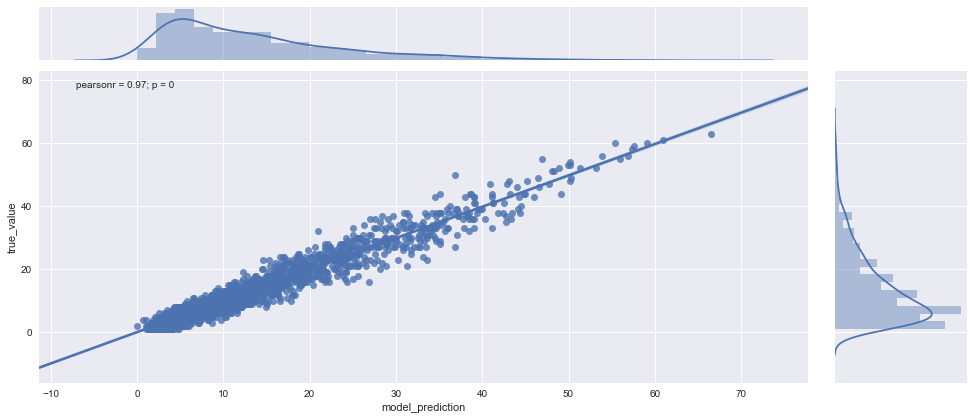

In [69]:
plot_joint_and_r_squared(xgb)

In [71]:
X_train

,L,mu,cvr,f,m,cs/cw
Inst ID,,,,,,
10948,1,10,2,0.5,2,10
956,1,6,5,0.0,4,1
4118,0,4,15,0.0,2,2
8487,1,4,7,0.2,2,5
9026,1,4,2,0.0,10,5
10947,1,10,2,0.5,2,5
13160,2,4,7,0.0,6,10
946,1,6,5,0.0,3,1
14983,2,10,7,0.2,6,5


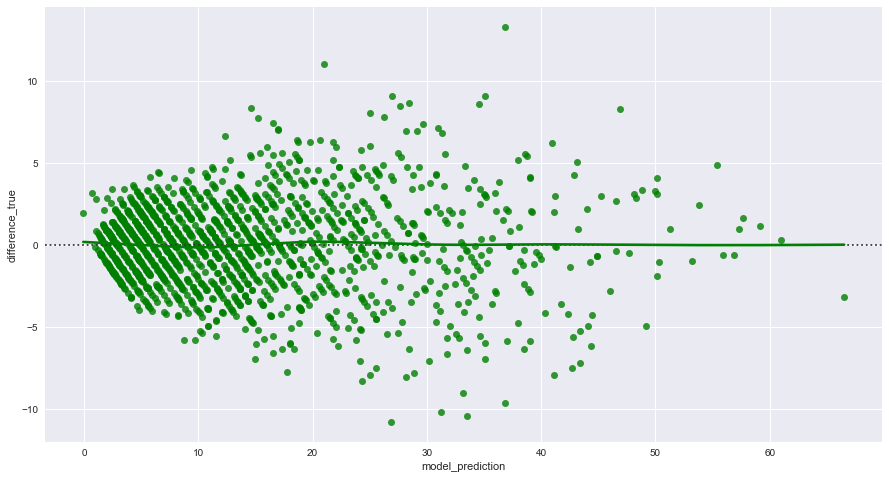

In [70]:
#This figure shows the residuals of the model with the x-axis containing the predicted value and the y-axis the
#difference between predicted and true. The residuals should be randomly distriburted and hover around 0 mean value
plot_residuals(xgb)

# Grid search to find the most optimal hyperparameters

In [57]:
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {'nthread':[4, 6], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.1], #so called `eta` value
              'max_depth': [5, 7, 10],
              'min_child_weight': [4,7,10],
              'silent': [1, 3],
              'subsample': [0.5, 0.7],
              'colsample_bytree': [0.3, 0.5],
              'n_estimators': [500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X,y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 10.4min finished


0.8462612652912339
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.5}
